# Closed-loop control of a 2D Drone
We consider a drone in this configuration living in a 2D environment, with gravity pointing down
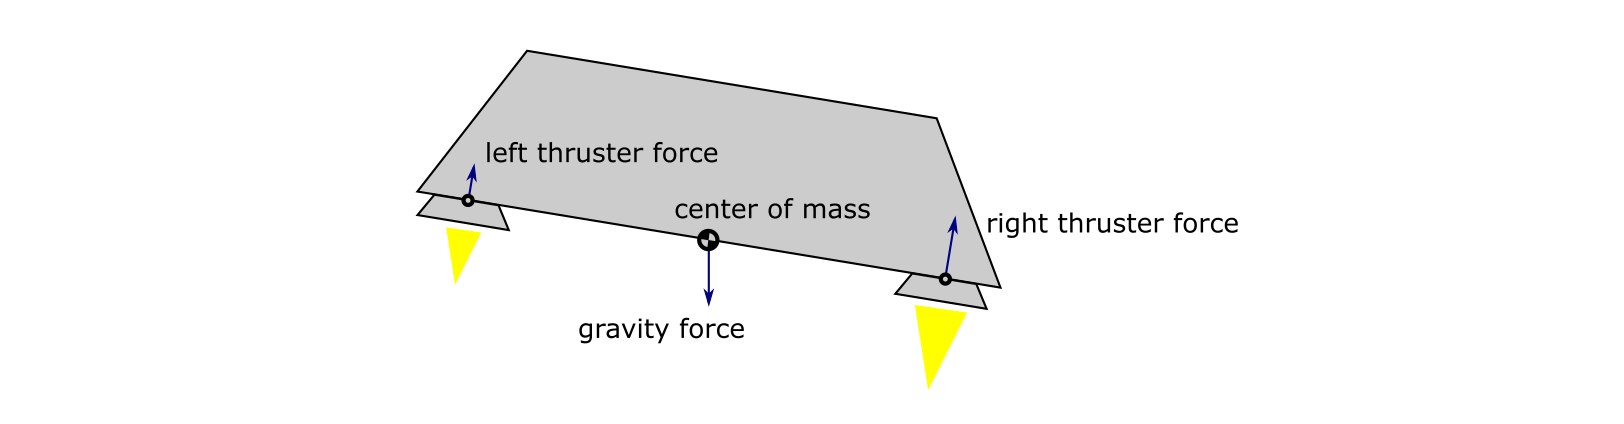

The first part of the notebook explains how the code is structured. If you just want to run the graphical simulation, you can skip to the end.

## Getting to grips with the simulation
First, let's see how the drone is simulated

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import ipywidgets as iw

In [2]:
import dronesim

initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
d = dronesim.Drone2D(
    initial_pose=initial_pose,
    mass=1,    # Total mass of the drone [Kg]
    L=1,       # Distance between the center of mass and each thruster [m]
    maxthrust=10 # maximum force [N] that each thurster can exert (we have 2!)
)

print(d) # this prints the drone position and angle (aka attitude)

Drone (0.00, 0.00) ∠ 0.0°


We can simulate what happens if we let some time pass while we do not fire the thrusters

In [3]:
d.step(thrustl_f=0, 
       thrustr_f=0, 
       dt=0.1)
print(d)

Drone (0.00, -0.10) ∠ 0.0°


The drone is... Falling!  Note the negative y.
We can get the drone coordinates and angle as follows

In [4]:
x,y = d.getxy()
theta = d.gettheta()
print(x,y,theta)

0.0 -0.09800000000000002 0.0


Let's run a freefall simulation

Text(0, 0.5, 'height [m]')

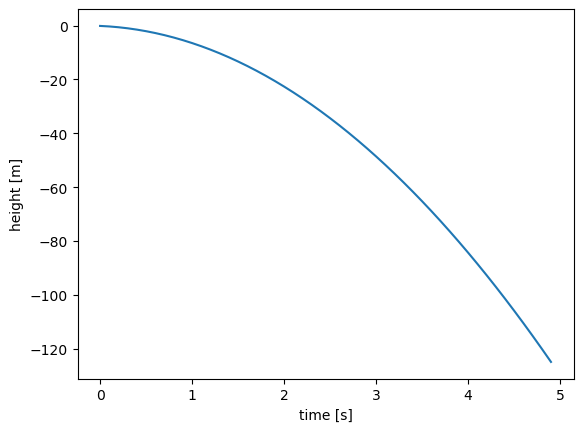

In [5]:
initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
d = dronesim.Drone2D(
    initial_pose=initial_pose,
    mass=1,    # Total mass of the drone [Kg]
    L=1,       # Distance between the center of mass and each thruster [m]
    maxthrust=10 # maximum force [N] that a thurster can exert
)
dt = 0.1 # timestep
ts = np.arange(0,5,dt)
xs,ys = [],[] # save here the x,y coordinates of the drone
for t in ts:
    d.step(thrustl_f=0, 
           thrustr_f=0, 
           dt=dt)
    x,y = d.getxy()
    xs.append(x)
    ys.append(y)
plt.plot(ts,ys)
plt.xlabel("time [s]")
plt.ylabel("height [m]")

It fell about 120 meters in 5 seconds.  Makes sense!
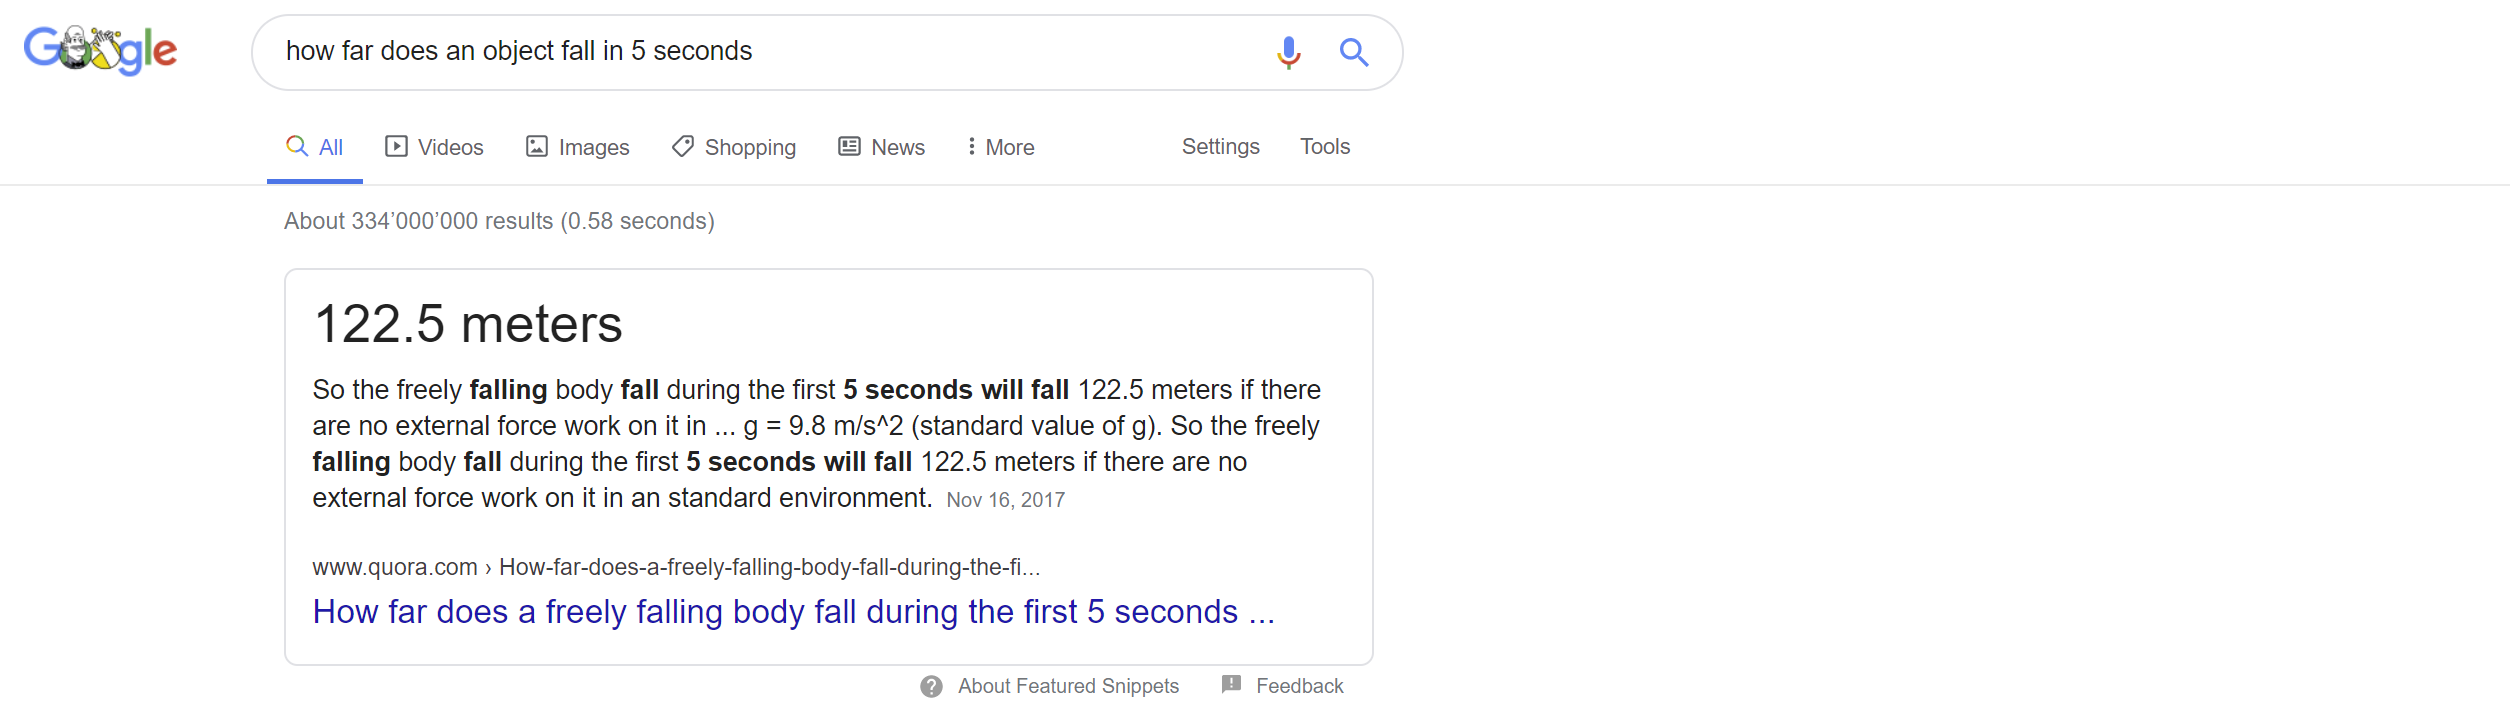

### Quiz!
How hard should we fire the thrusters in order to stay in place and not fall?

## Adding a controller to our drone

Say we want to reach a given point and stay there.
We need to modulate the thruster power over time, according to our current height.

We can do that by creating a controller class.  Its `step` function will take as parameters:
- the current `x`,`y`,`theta` of our drone;
- the position we want to reach (`target_x`, `target_y`);
- and the timestep duration `dt`

The function will return a tuple with the desired thrust from the left and right thrusters.

In [6]:
class Controller():
    def __init__(self, maxthrust):
        self.maxthrust=maxthrust
    
    def step(self, 
             x, y, theta, # sensor measurements
             target_x, target_y, dt):
        return 0, 0 # This controller does not even try to be smart

Once I have a controller instance and a drone instance, we can simulate the latter controlled by the former using the `ControlledDrone` class.

In [7]:
initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=10)
c = Controller(d.maxthrust)
cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=5)

For each timestep, the `ControlledDrone` class will:
- read the drone `x`,`y`,`theta`
- call the controller's `step` function feeding this data and the current `target_x` and `target_y`
- read the returned control signals (left and right thrusters) and call the drone's step function accordingly

In [8]:
# execute this cell multiple times to check what happens...
cd.step(dt = 0.1)
print(d)

Drone (0.00, -0.10) ∠ 0.0°


Let's now simulate a controlled drone for some time and draw its height

In [9]:
def simulate(cd): # given a ControlledDrone instance...
    dt = 0.1 # timestep
    ts = np.arange(0,10,dt)
    ys = [] # save here the y coordinates of the drone
    for t in ts:
        cd.step(dt)
        x,y = cd.drone.getxy()
        ys.append(y)
    fig,ax = plt.subplots(figsize=(8,4))
    ax.plot(ts,ys)
    ax.set(ylabel="y [m]", xlabel = "time [s]")
    

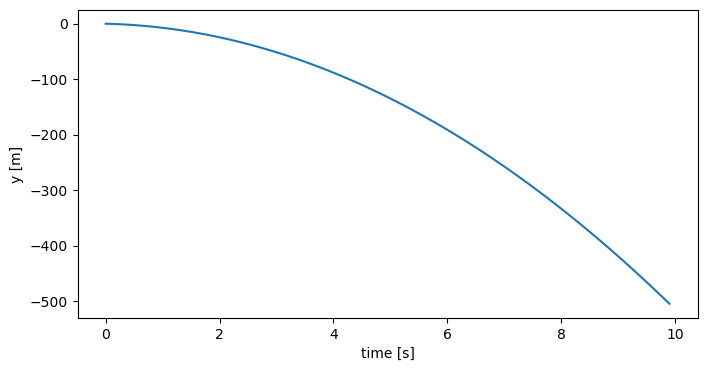

In [10]:
simulate(cd)

## A PID height controller
We can control the drone height with a PID

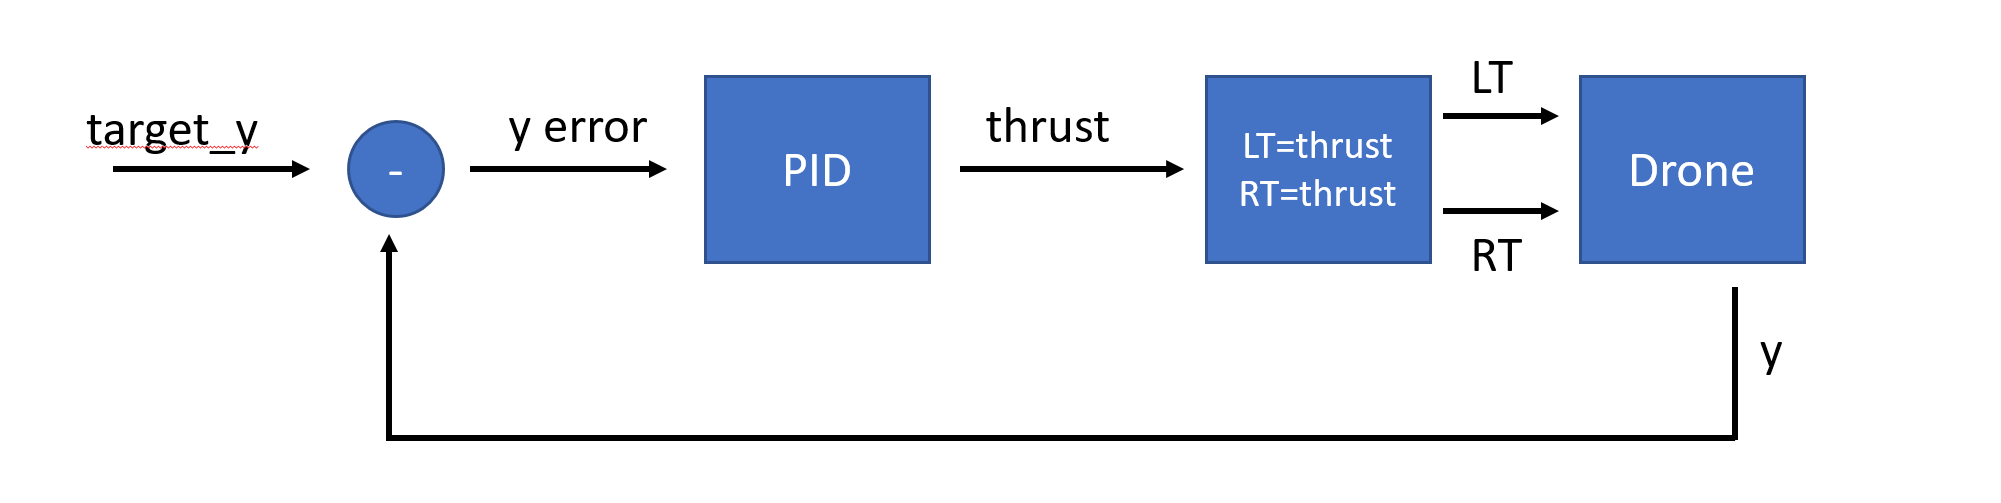

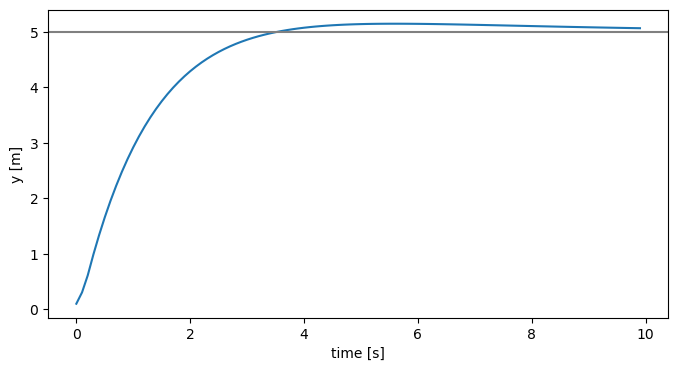

In [11]:
from pid import PID

class Controller():
    def __init__(self, maxthrust):
        self.maxthrust=maxthrust
        self.y_pid = PID(Kp=5,Ki=1,Kd=5)
    
    def step(self, x, y, theta, target_x, target_y, dt):
        e = target_y - y
        thrust = self.y_pid.step(e, dt)
        lt = thrust
        rt = thrust
        return lt, rt

initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=10)
c = Controller(d.maxthrust)
cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=5)
simulate(cd)
plt.gca().axhline(cd.target_y, color="gray")

## Let's explore the PID parameters

In [12]:
@iw.interact(Kp=(0.0,20.0),Ki=(0.0,20.0),Kd=(0.0,20.0))
def f(Kp=0,Ki=0,Kd=0):
    class Controller():
        def __init__(self, maxthrust):
            self.maxthrust=maxthrust
            self.y_pid = PID(Kp,Ki,Kd)

        def step(self, x, y, theta, target_x, target_y, dt):
            e = target_y - y
            thrust = self.y_pid.step(e, dt)
            lt = thrust
            rt = thrust
            return lt, rt
    
    initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
    d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=10)
    c = Controller(d.maxthrust)
    cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=5)
    simulate(cd)
    plt.gca().axhline(cd.target_y, color="gray")

interactive(children=(FloatSlider(value=0.0, description='Kp', max=20.0), FloatSlider(value=0.0, description='…

# Exercise
## Step 1
In practice, you will need a way to also control the robot angle (attitude).  You can act on the robot angle by "pushing" more with one of the two thrusters.  For example, if you push more with the right thruster, the robot rotational velocity will increase.

Implement a single controller that keeps the drone horizontal (`theta = 0`) and at a target height (`target_y = 0`) even if the drone initially is not horizontal 

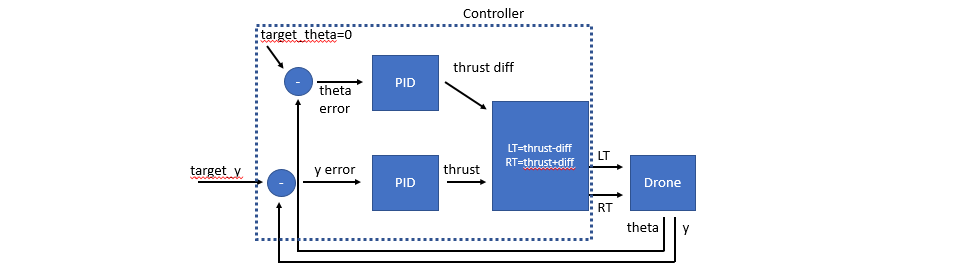

## Step 2

Now that we can control theta, we can use that to exert an horizontal acceleration to the drone.
Therefore, we can now control its position!

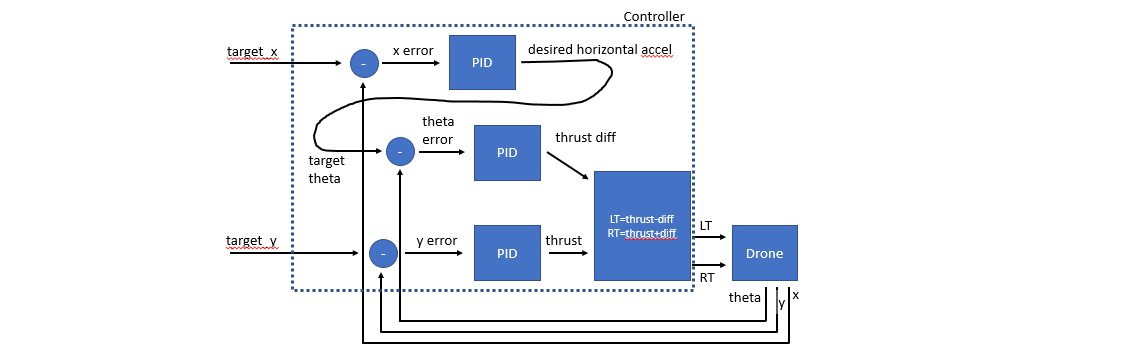

## Read your controller from a module file and simulate it
This reads a controller from the `controller.py` file in the current directory and simulates the drone contained there.

In [13]:
def simulate(cd): # simulate a ControlledDrone instance...
    dt = 0.03 # timestep
    ts = np.arange(0,5,dt)
    xs,ys,thetas,lts,rts = [],[],[],[],[] # save here the x,y,theta coordinates of the drone
    for t in ts:
        cd.step(dt)
        x,y = cd.drone.getxy()
        xs.append(x)
        ys.append(y)
        lts.append(cd.drone.lt)
        rts.append(cd.drone.rt)
        thetas.append(cd.drone.gettheta())
    fig,axs = plt.subplots(nrows=4, sharex=True, figsize=(8,12))
    axs[0].plot(ts,xs)
    axs[0].set(ylabel="x position [m]")
    axs[1].plot(ts,ys)
    axs[1].set(ylabel="height [m]")
    axs[2].plot(ts,np.rad2deg(thetas))
    axs[2].set(ylabel="theta [deg]")
    axs[3].plot(ts,lts)
    axs[3].plot(ts,rts)
    axs[3].set(ylabel="thrust [N]", xlabel = "time [s]")

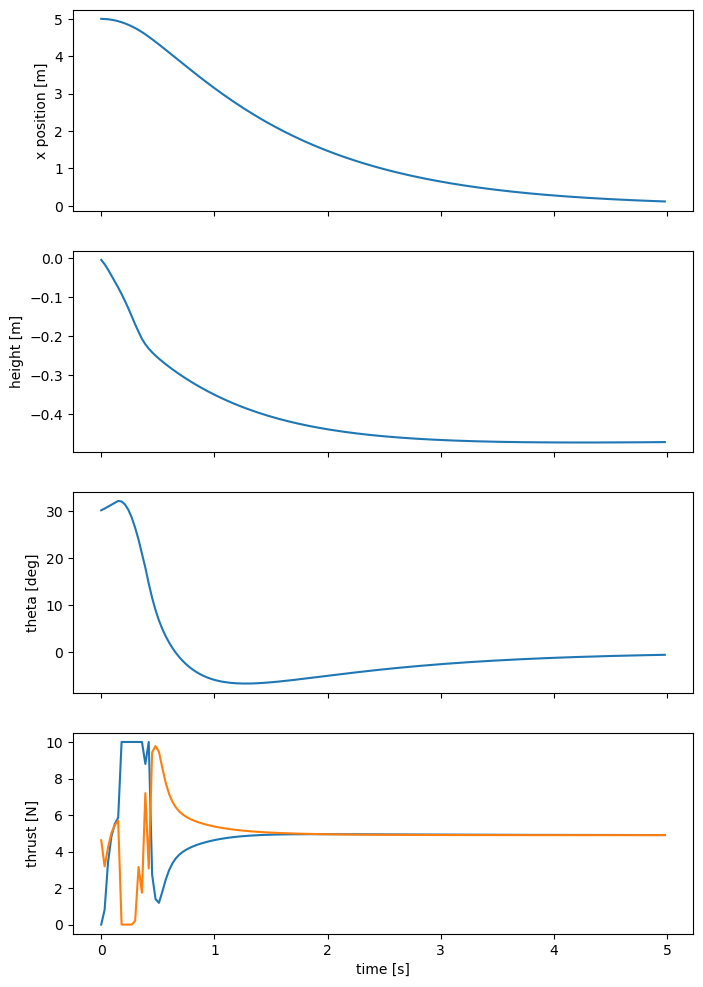

In [14]:
import good_controller as cont
importlib.reload(cont) # make sure we have the latest version if it was edited
initial_pose = dronesim.mktr(5,0) @ dronesim.mkrot(np.deg2rad(30))
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=10)
c = cont.Controller(maxthrust=d.maxthrust)
cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=0)
simulate(cd)

# Simulate and visualize your drone!
This requires that the `arcade` library is installed in your system, which is used for visualization: `pip install arcade`.

Once it is installed, you can run the simulation with:
`python droneviz.py`

Within the simulation, you can do the following:
- CLICK: change `target_x` and `target_y`. The current target position is visualized as a red square.
- SPACE: instantiate a new drone in (0,0), controlled by the controller defined in `controller.py`.  You can change that file and instantiate a new drone without relaunching the simulator.
- A and S: perturb the current rotation of all drones by 30 degrees clockwise or counterclockwise.
- UP and DOWN: zoom in/out
- Q: quit

You can also run the simulation from within this notebook, but it might fail if you quit and run it again without restarting the kernel.

In [15]:
import controller as cont
importlib.reload(cont) # make sure we are using the latest version, in case the file changed
initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(np.deg2rad(0))
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=5)

In [16]:
# Visualize our drone
import droneviz
importlib.reload(droneviz)
import arcade
g = droneviz.DroneViz()
g.controlled_drones.append(cd)
arcade.run()

UNSUPPORTED (log once): gldCopyBufferSubData: NEEDS IMPLEMENTATION


-44.68126659781644 30.69937364883986
-0.40527225939062816 3.1408600102773505
[[ 9.81806045e-01  1.89886516e-01  1.82361020e+01]
 [-1.89886516e-01  9.81806045e-01 -2.75464531e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-5.45105597e-02 -9.98513194e-01  1.86906305e+01]
 [ 9.98513194e-01 -5.45105597e-02 -2.86398447e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.93344356e-01  1.15182421e-01  1.88493240e+01]
 [-1.15182421e-01 -9.93344356e-01 -2.95866752e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[   0.89109629    0.45381428   19.28793766]
 [  -0.45381428    0.89109629 -314.08593563]
 [   0.            0.            1.        ]]
-0.9118625836289098 14.3871652083672
-0.8105445187812492 3.850086464210939
-0.9118625836289098 -7.497536798726568
0.20263612969531408 -14.083211013824226
-0.8105445187812492 4.356676788449228
-1.3171348430195309 21.378111682855483
-35.96791302091799 20.060976839835952
-35.56264076152737 26.646651054933606
-23.80974523919923

In [ ]:
import controller as cont
importlib.reload(cont) # make sure we are using the latest version, in case the file changed
initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(np.deg2rad(0))

d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
cd = dronesim.ControlledDrone(drone=d, controller=c, target_y=5)

In [ ]:
# Visualize our drone
import droneviz
importlib.reload(droneviz)
import arcade
g = droneviz.DroneViz()
g.controlled_drones.append(cd)
arcade.run()